In [1]:
# Import modules
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import h5py
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from sklearn.metrics import mean_squared_error, mean_absolute_error
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# Load the pre-trained model
model_path = './output/WP_12framesconvLSTM_overlap/WP_12framesconvLSTM_overlap.h5'
model = load_model(model_path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2024-10-14 11:32:16.815947: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-10-14 11:32:16.869209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-14 11:32:16.869414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Quadro P5000 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:03:00.0
2024-10-14 11:32:16.869581: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/anaconda3/envs/gt/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda-11.5/lib64:
2024-10-14 11:32:16.869702: W tensorflow/stream_executor/platform/default/dso_loade

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
# Load the dataset
with h5py.File('./dataset/12framesRGB_overlap.h5', 'r') as hf:
    train_dataset = hf["train"][:]
    val_dataset = hf["val"][:]
    test_dataset = hf["test"][:]

In [4]:
# Create input(x) and label(y)
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 12, :, :]
    y = data[:, 12 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
x_test, y_test = create_shifted_frames(test_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))
print("Test Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (6308, 6, 64, 64, 3), (6308, 6, 64, 64, 3)
Validation Dataset Shapes: (1802, 6, 64, 64, 3), (1802, 6, 64, 64, 3)
Test Dataset Shapes: (902, 6, 64, 64, 3), (902, 6, 64, 64, 3)


In [4]:
# Creating output folder
output_dir = './output/WP_12framesconvLSTM_overlap'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [5]:
# Select a few random examples from the dataset.
# example = test_dataset[np.random.choice(range(len(test_dataset)), size=1)[0]]
# print(example.shape)

# select a fixed example index
example_index = 13   # Change as needed
example = test_dataset[example_index]
print(example.shape)

# Pick the first/last ten frames from the example.
frames = example[:12, ...]
original_frames = example[12:, ...]

# predict the next 18 fames
new_prediction = model.predict(np.expand_dims(frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)

# Print the dimensions of your images
print("Original Frames Shape:", original_frames.shape)
print("New Prediction Shape:", new_prediction.shape)

# Reshape and preprocess your data if needed
new_prediction = new_prediction.reshape((-1, 64, 64, 1))
original_frames = original_frames.reshape((-1, 64, 64, 1))

# Initialize variables
batch_size = len(new_prediction)
mse_total = 0
mae_total = 0
pmae_total = 0

# Loop through each example in the batch
for i in range(batch_size):
    pmae = 0
    for j in range(12):  # Assuming you want to evaluate the first 10 frames
        mse_total += mean_squared_error(original_frames[i, j], new_prediction[i, j])
        mae_total += mean_absolute_error(original_frames[i, j], new_prediction[i, j])
        pmae += 1.0 - mean_absolute_error(original_frames[i, j], new_prediction[i, j])
    pmae_total += pmae * 100

# Calculate metrics
mse = mse_total / (batch_size * 12)
mae = mae_total / (batch_size * 12)
pmae_total = pmae_total / (batch_size * 12)

print('MSE: ', mse)
print('MAE: ', mae)
print('PMAE: ', pmae_total)

(24, 64, 64, 3)
Original Frames Shape: (12, 64, 64, 3)
New Prediction Shape: (12, 64, 64, 3)
MSE:  6.210227964574441e-07
MAE:  0.0004776891373106689
PMAE:  99.95223108626894


In [9]:
# Select a few random examples from the dataset.
# examples = test_dataset[np.random.choice(range(len(test_dataset)), size=5)]

# Select fixed examples (e.g., first 5 samples)
# You can either use specific indices like:
fixed_indices = [1, 4, 11, 21, 25]  # Change as needed

examples = test_dataset[fixed_indices]  # Select those examples



# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:12, ...]
    original_frames = example[12:, ...]
    new_predictions = np.zeros(shape=(12, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(12):
        # Extract the model's prediction and post-process it.
        frames = example[: 12 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = (current_frames * 255).astype(np.uint8)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], layout=Layout(width='150px', height='150px')),
            widgets.Image(value=predicted_videos[i + 1], layout=Layout(width='150px', height='150px')),
        ]
    )
    display(box)

Truth	Prediction


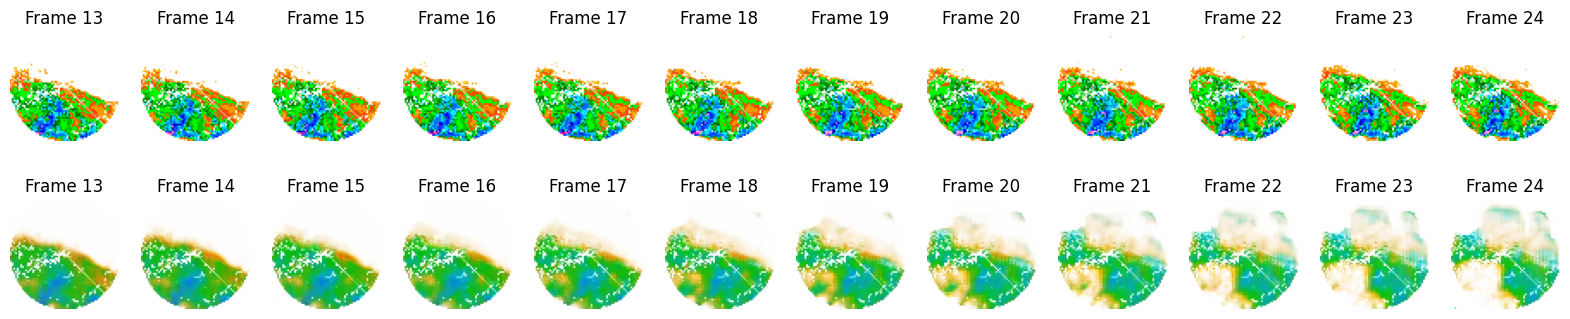

In [10]:
# Select a random example from the validation dataset.
# example = test_dataset[np.random.choice(range(len(test_dataset)), size=1)[0]]

# Choose a specific example from the validation dataset (e.g., index 0)
example_index = 4  # Change this to the desired index
example = test_dataset[example_index]

# Pick the first/last ten frames from the example.
frames = example[:12, ...]
original_frames = example[12:, ...]

# Predict a new set of 10 frames.
for _ in range(12):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

 # Evaluate the model
# accuracy = mean_squared_error(original_frames, frames)

# # Print the evaluation metrics
# print(f"Accuracy: {accuracy}")


# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 12, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(original_frames[idx])
    ax.set_title(f"Frame {idx + 13}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[12:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(new_frames[idx])
    ax.set_title(f"Frame {idx + 13}")
    ax.axis("off")

# Display the figure.
plt.show()